In [6]:
import pandas as pd
import numpy as np
from endless_line.data_utils.dataloader import DataLoader

In [7]:
data = DataLoader(load_all_files=True)
data.clean_data()
data.data_preprocessing_attendance_pred()

In [8]:
df = data.attendance
df.head()

,USAGE_DATE,attendance
0,2020-06-01,46804
2,2020-06-02,57940
4,2020-06-03,44365
6,2020-06-04,37617
8,2020-06-05,32438


In [10]:
df_weather = data.weather
df_weather.head()

,dt_iso,temp,feels_like,pressure,wind_speed,clouds_all,weather_description_encoded,weather_main_encoded,day,month,day_of_week
166572,2020-01-01,0.327915,0.311923,0.312500,0.791500,0.99,5,2,1,1,2
166596,2020-01-02,0.319687,0.333960,0.578125,0.349639,0.99,4,1,2,1,3
166620,2020-01-03,0.334537,0.320977,0.468750,0.761828,0.43,2,1,3,1,4
166644,2020-01-04,0.449930,0.488896,0.359375,0.720930,1.00,5,2,4,1,5
166668,2020-01-05,0.367851,0.378715,0.343750,0.420209,1.00,4,1,5,1,6


In [12]:
# Convert dt_iso to datetime in df_weather
df_weather['dt_iso'] = pd.to_datetime(df_weather['dt_iso'])

# Merge the dataframes
merged_df = pd.merge(df, df_weather, left_on='USAGE_DATE', right_on='dt_iso')

# Display the first few rows of the merged dataframe
merged_df.head()

# Drop the dt_iso column
merged_df = merged_df.drop(columns=['dt_iso', 'feels_like', 'clouds_all', 'weather_main_encoded'])



# 2. Define the cutoff date and compute the start of the last 3 months.
cutoff_date = pd.Timestamp("2022-01-01")

# Determine the maximum date in the dataset.
max_date = merged_df['USAGE_DATE'].max()

# Define the start of the last 3 months.
# Here, we use DateOffset to go back 3 months.
last_3_months_start = max_date - pd.DateOffset(months=3) + pd.Timedelta(days=1)
# (Adjust the calculation if you prefer a slightly different definition of "3 months.")

# 3. Partition the data into two blocks:
#    - Block 1: Data with dates before January 1, 2022.
#    - Block 2: Data from the last 3 months of the dataset.
block1 = merged_df[merged_df['USAGE_DATE'] < cutoff_date].copy()
#block2 = merged_df[merged_df['USAGE_DATE'] >= last_3_months_start].copy()

# 4. Adjust the dates in Block 1 so that the USAGE_DATE column becomes continuous.
#    We want the last date in Block 1 to be exactly one day before the first date in Block 2.
#if not block1.empty and not block2.empty:
    # Original last date in Block 1
#    block1_last_original = block1['USAGE_DATE'].max()
    # First date in Block 2
#    block2_first_date = block2['USAGE_DATE'].min()
    # New desired last date for Block 1 (one day before Block 2 starts)
#    new_block1_last = block2_first_date - pd.Timedelta(days=1)
    
    # Calculate the constant offset needed to shift Block 1 dates.
#    offset = new_block1_last - block1_last_original

    # Apply the offset to all dates in Block 1.
#    block1['USAGE_DATE'] = block1['USAGE_DATE'] + offset

# 5. Merge the two blocks and sort by the (adjusted) USAGE_DATE.
#merged = pd.concat([block1, block2]).sort_values(by='USAGE_DATE').reset_index(drop=True)
merged = block1.sort_values(by='USAGE_DATE')

# Display the first few rows of the merged dataframe
merged.head()

,USAGE_DATE,attendance,temp,pressure,wind_speed,weather_description_encoded,day,month,day_of_week
0,2020-06-01,46804,0.568734,0.656250,0.204491,5,1,6,0
1,2020-06-02,57940,0.613084,0.656250,0.077787,4,2,6,1
2,2020-06-03,44365,0.656231,0.609375,0.218925,4,3,6,2
3,2020-06-04,37617,0.641180,0.515625,0.174820,2,4,6,3
4,2020-06-05,32438,0.544250,0.515625,0.300722,4,5,6,4


In [36]:
from datetime import datetime, timedelta

# Load your DataFrame (replace with actual loading method)
merged_df["USAGE_DATE"] = pd.to_datetime(merged_df["USAGE_DATE"])

# Get the maximum date in the dataset
max_date = merged_df["USAGE_DATE"].max()

# Determine target date (today if after noon, yesterday if before noon)
now = datetime.now()
target_date = datetime.today().date() if now.hour >= 12 else (datetime.today() - timedelta(days=1)).date()

# Compute the shift needed
days_to_shift = (pd.Timestamp(target_date) - max_date).days

# Apply the shift
merged_df["USAGE_DATE"] = merged_df["USAGE_DATE"] + pd.Timedelta(days=days_to_shift)

merged_df['USAGE_DATE'] = merged_df['USAGE_DATE'].dt.date


merged_df.head()

,USAGE_DATE,attendance,temp,pressure,wind_speed,weather_description_encoded,day,month,day_of_week
0,2022-12-19,46804,0.568734,0.656250,0.204491,5,1,6,0
1,2022-12-20,57940,0.613084,0.656250,0.077787,4,2,6,1
2,2022-12-21,44365,0.656231,0.609375,0.218925,4,3,6,2
3,2022-12-22,37617,0.641180,0.515625,0.174820,2,4,6,3
4,2022-12-23,32438,0.544250,0.515625,0.300722,4,5,6,4


In [37]:
from endless_line.data_utils.weather_forecast import WeatherForecast
from sklearn.preprocessing import MinMaxScaler


# Create an instance of the WeatherForecast class
forecast = WeatherForecast()
forecast_data = forecast.get_forecast()

# Drop columns

forecast_data["day"] = forecast_data["dt_iso"].dt.day
forecast_data["month"] = forecast_data["dt_iso"].dt.month
forecast_data["day_of_week"] = forecast_data["dt_iso"].dt.dayofweek

forecast_data = forecast_data[forecast_data['dt_iso'].dt.hour == 12].copy()
forecast_data['dt_iso'] = forecast_data['dt_iso'].dt.date
weather_mapping = {
			'sky is clear': 0,
			'few clouds': 1,
			'scattered clouds': 2,
			'broken clouds': 3,
			'overcast clouds': 4,
			'light rain': 5,
			'moderate rain': 6,
			'heavy intensity rain': 7,
			'light snow': 8,
			'snow': 9
		}
forecast_data['weather_description_encoded'] = forecast_data['weather_description'].map(weather_mapping)
forecast_data = forecast_data.drop(columns=['humidity', 'feels_like', 'weather_main', 'weather_icon', 'clouds_all', 'weather_description'])


scaler = MinMaxScaler()
num_cols = ['temp', 'pressure', 'wind_speed']
forecast_data[num_cols] = scaler.fit_transform(forecast_data[num_cols])

forecast_data.tail(10)

/Users/jonathanpiscart/Hackathon-ElevenStrategy/endless_line/data_utils/weather_forecast.py:66: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  forecast_df = forecast_df.set_index('dt_iso').resample('h').interpolate(method='ffill', limit_direction='forward')


,dt_iso,temp,pressure,wind_speed,day,month,day_of_week,weather_description_encoded
15,2025-02-12,0.247423,0.125,0.000000,12,2,2,4
39,2025-02-13,0.855670,0.625,0.452128,13,2,3,2
63,2025-02-14,0.020619,1.000,1.000000,14,2,4,3
87,2025-02-15,0.000000,0.500,0.707447,15,2,5,3
111,2025-02-16,1.000000,0.000,0.164894,16,2,6,4


In [38]:
# Rename dt_iso to USAGE_DATE in forecast_data
forecast_data.rename(columns={'dt_iso': 'USAGE_DATE'}, inplace=True)

# Add a column attendance with null values to forecast_data
forecast_data['attendance'] = np.nan

# Concatenate merged_df with forecast_data
combined_df = pd.concat([merged_df, forecast_data], ignore_index=True)

# Display the first few rows of the combined dataframe
combined_df.tail(10)

,USAGE_DATE,attendance,temp,pressure,wind_speed,weather_description_encoded,day,month,day_of_week
781,2025-02-07,49586.0,0.651615,0.609375,0.308741,5,22,7,4
782,2025-02-08,51748.0,0.673691,0.656250,0.148356,4,23,7,5
783,2025-02-09,45261.0,0.771222,0.609375,0.207698,2,24,7,6
784,2025-02-10,53764.0,0.674493,0.562500,0.535686,4,25,7,0
785,2025-02-11,26391.0,0.602649,0.640625,0.209302,4,26,7,1
786,2025-02-12,NaN,0.247423,0.125000,0.000000,4,12,2,2
787,2025-02-13,NaN,0.855670,0.625000,0.452128,2,13,2,3
788,2025-02-14,NaN,0.020619,1.000000,1.000000,3,14,2,4
789,2025-02-15,NaN,0.000000,0.500000,0.707447,3,15,2,5
790,2025-02-16,NaN,1.000000,0.000000,0.164894,4,16,2,6


In [39]:
import pandas as pd
from prophet import Prophet
import numpy as np

df_new = combined_df.copy()

# Rename columns if needed for Prophet
df_new.rename(columns={'USAGE_DATE': 'ds', 'attendance': 'y'}, inplace=True)

# Ensure ds is datetime and sorted by ds
df_new['ds'] = pd.to_datetime(df_new['ds'])
df_new.sort_values('ds', inplace=True)

# Separate the rows we can use to train (non-NaN in 'y')
df_train = df_new[~df_new['y'].isna()].copy()

# Separate the rows we want to predict (NaN in 'y') -- last 5 days
df_future = df_new[df_new['y'].isna()].copy()


In [46]:
m = Prophet()

# Add extra regressors just like before
m.add_regressor('temp')
m.add_regressor('pressure')
m.add_regressor('wind_speed')
m.add_regressor('weather_description_encoded')
m.add_regressor('day')
m.add_regressor('month')
m.add_regressor('day_of_week')

# Fit on df_train only (the rows where attendance is known)
m.fit(df_train)

forecast_future = m.predict(df_future)

# forecast_future will include columns like 'yhat', 'yhat_lower', 'yhat_upper', etc.
print(forecast_future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

# Create a new column in df_new to hold the predictions
df_new['predicted_attendance'] = np.nan

# Align the predictions by ds
for i, row in forecast_future.iterrows():
    ds_value = row['ds']
    yhat_value = row['yhat']
    df_new.loc[df_new['ds'] == ds_value, 'predicted_attendance'] = yhat_value

# Now df_new has 'predicted_attendance' for those 5 NaN rows
print(df_new.tail(10))

21:03:44 - cmdstanpy - INFO - Chain [1] start processing
21:03:44 - cmdstanpy - INFO - Chain [1] done processing


          ds          yhat    yhat_lower    yhat_upper
0 2025-02-12  28266.832257  16062.808607  40269.425370
1 2025-02-13  38962.924141  27570.986045  50355.098438
2 2025-02-14  32917.425750  20504.350672  43418.356340
3 2025-02-15  27751.755780  16790.399200  38968.499015
4 2025-02-16  37258.597599  26312.854429  48605.421067
            ds        y      temp  pressure  wind_speed  \
781 2025-02-07  49586.0  0.651615  0.609375    0.308741   
782 2025-02-08  51748.0  0.673691  0.656250    0.148356   
783 2025-02-09  45261.0  0.771222  0.609375    0.207698   
784 2025-02-10  53764.0  0.674493  0.562500    0.535686   
785 2025-02-11  26391.0  0.602649  0.640625    0.209302   
786 2025-02-12      NaN  0.247423  0.125000    0.000000   
787 2025-02-13      NaN  0.855670  0.625000    0.452128   
788 2025-02-14      NaN  0.020619  1.000000    1.000000   
789 2025-02-15      NaN  0.000000  0.500000    0.707447   
790 2025-02-16      NaN  1.000000  0.000000    0.164894   

     weather_descrip

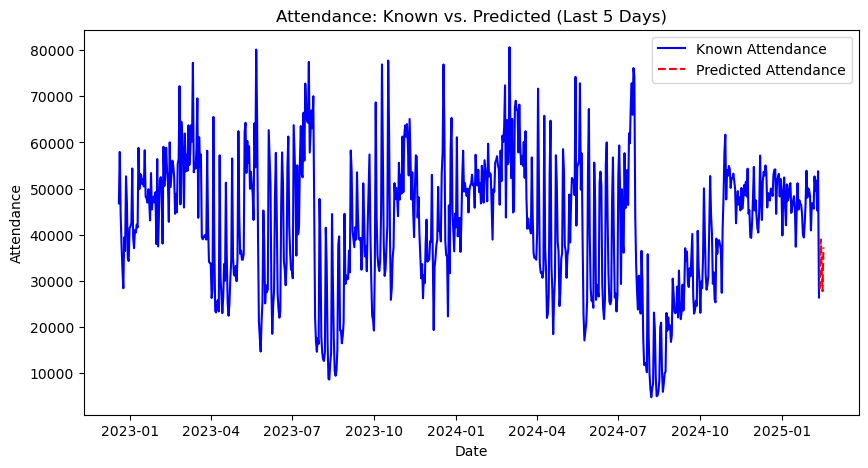

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

# Plot the known attendance
df_known = df_new[~df_new['y'].isna()]
plt.plot(df_known['ds'], df_known['y'], label='Known Attendance', color='blue')

# Plot the predicted attendance
df_pred = df_new[df_new['predicted_attendance'].notna()]
plt.plot(df_pred['ds'], df_pred['predicted_attendance'], label='Predicted Attendance', color='red', linestyle='--')

plt.title('Attendance: Known vs. Predicted (Last 5 Days)')
plt.xlabel('Date')
plt.ylabel('Attendance')
plt.legend()
plt.show()


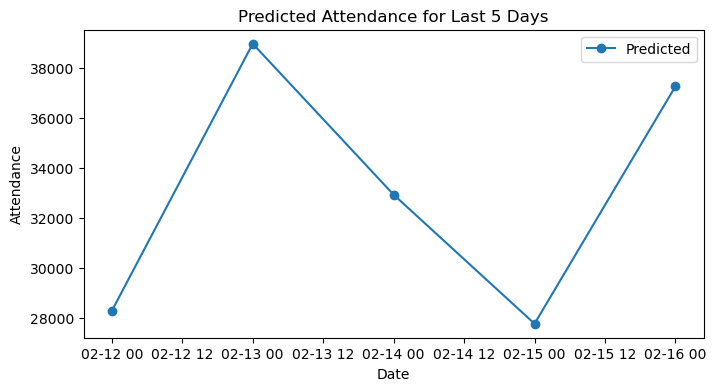

In [48]:
import matplotlib.pyplot as plt

# Filter only the future portion
df_plot_future = df_new[df_new['ds'].isin(df_future['ds'])]

plt.figure(figsize=(8,4))
plt.plot(df_plot_future['ds'], df_plot_future['predicted_attendance'], marker='o', label='Predicted')
plt.title('Predicted Attendance for Last 5 Days')
plt.xlabel('Date')
plt.ylabel('Attendance')
plt.legend()
plt.show()


In [62]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Same data splitting
X = merged[['temp', 'pressure', 'wind_speed', 'weather_description_encoded', 'day', 'month', 'day_of_week']]
y = merged['attendance']

split_index = int(len(X) * 0.9)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Initialize and train CatBoost
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    verbose=100,
    random_seed=42
)

cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

# Predict
y_pred_cat = cat_model.predict(X_test)

# Evaluate
mse_cat = mean_squared_error(y_test, y_pred_cat)
rmse_cat = np.sqrt(mse_cat)
print(f'CatBoost RMSE: {rmse_cat:.2f}')


0:	learn: 13982.5146451	test: 16747.9264749	best: 16747.9264749 (0)	total: 942us	remaining: 942ms
100:	learn: 5651.7567049	test: 9152.5686519	best: 9152.5686519 (100)	total: 99.7ms	remaining: 888ms
200:	learn: 3652.9158236	test: 9126.8150036	best: 9108.7428650 (167)	total: 136ms	remaining: 542ms
300:	learn: 2581.7829464	test: 9038.2730248	best: 9022.8798924 (290)	total: 172ms	remaining: 399ms
400:	learn: 1989.1179939	test: 8993.0144142	best: 8964.7563543 (359)	total: 209ms	remaining: 312ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 8964.756354
bestIteration = 359

Shrink model to first 360 iterations.
CatBoost RMSE: 8964.76


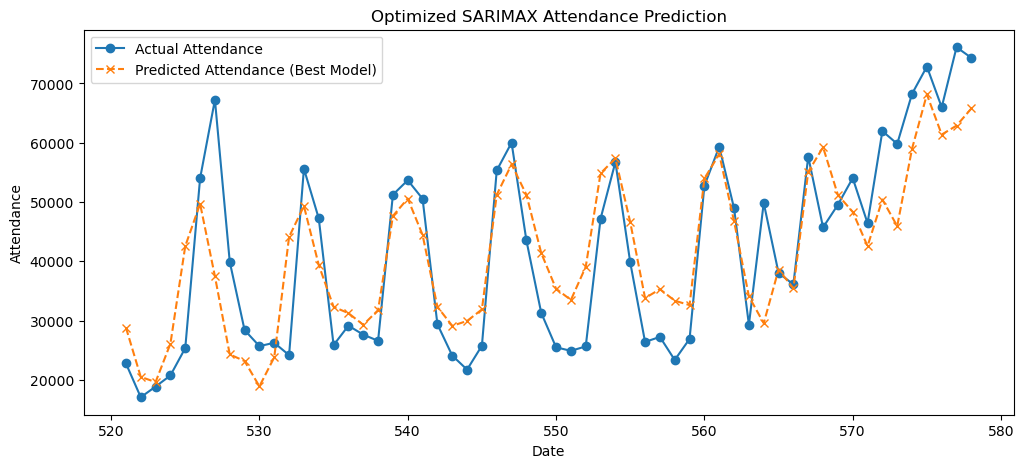

In [63]:
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label="Actual Attendance", marker='o')
plt.plot(y_test.index, y_pred_cat, label="Predicted Attendance (Best Model)", marker='x', linestyle='dashed')
plt.legend()
plt.title("Optimized SARIMAX Attendance Prediction")
plt.xlabel("Date")
plt.ylabel("Attendance")
plt.show()

In [65]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                       Feature       VIF
0                         temp  8.895551
1                     pressure  9.752199
2                   wind_speed  4.304641
3  weather_description_encoded  3.779283
4                          day  4.123117
5                        month  4.831384
6                  day_of_week  3.153880


In [26]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


#merged_df.set_index('USAGE_DATE', inplace=True)
# Define target and exogenous features
y = merged['attendance']
X = merged[['temp', 'pressure', 'wind_speed',
               'weather_description_encoded', 'day', 'month']]

# Scale exogenous variables (SARIMAX is sensitive to scale)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test
split = int(len(y) * 0.9)  # 80% train, 20% test
y_train, y_test = y[:split], y[split:]
X_train, X_test = X_scaled[:split], X_scaled[split:]


# Define SARIMAX model
sarimax_model = SARIMAX(y_train, 
                        exog=X_train, 
                        order=(1, 1, 1), 
                        seasonal_order=(0, 1, 2, 7),  # Weekly seasonality
                        enforce_stationarity=False, 
                        enforce_invertibility=False)

# Fit the model
sarimax_result = sarimax_model.fit()
print(sarimax_result.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00259D+01    |proj g|=  8.20116D-02


 This problem is unconstrained.



At iterate    5    f=  9.99625D+00    |proj g|=  1.36711D-01
  ys=-2.378E-03  -gs= 1.090E-02 BFGS update SKIPPED

At iterate   10    f=  9.98585D+00    |proj g|=  1.81411D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     14     32      1     1     0   4.365D-05   9.986D+00
  F =   9.9858005295943180     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                       SARIMAX Results                                        
Dep. Variable:                             attendance   No. Observations:                  521
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 7)   L

In [27]:
# Predict on test set
y_pred = sarimax_result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)

# Evaluate MSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 173627952.2310435


In [30]:
print(np.sqrt(173627952))

13176.795968671595


Performance of SARIMAX 111, 0127 : 13k
Performace with xgboost, 90% of data : 8,4k (7k for CatBoost)
Preformance of Prophet : 90% : 12k

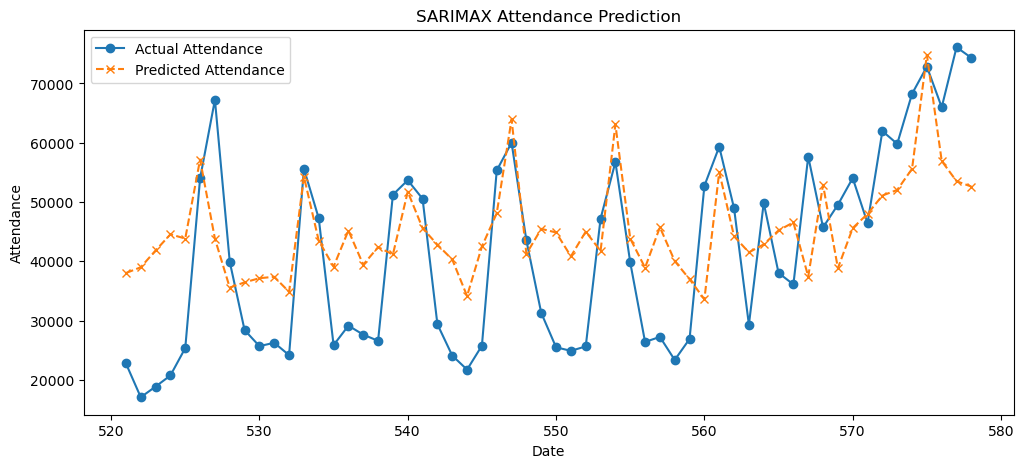

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label="Actual Attendance", marker='o')
plt.plot(y_test.index, y_pred, label="Predicted Attendance", marker='x', linestyle='dashed')
plt.legend()
plt.title("SARIMAX Attendance Prediction")
plt.xlabel("Date")
plt.ylabel("Attendance")
plt.show()


In [21]:
import itertools
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Define parameter grid
p = range(0, 3)  # Autoregressive terms
d = range(0, 2)  # Differencing
q = range(0, 3)  # Moving average terms

P = range(0, 3)  # Seasonal autoregressive
D = range(0, 2)  # Seasonal differencing
Q = range(0, 3)  # Seasonal moving average
s = [7]  # Weekly seasonality

# Generate all parameter combinations
param_combinations = list(itertools.product(p, d, q, P, D, Q, s))
print(f"Testing {len(param_combinations)} parameter combinations...")


Testing 324 parameter combinations...


In [22]:
# Store results
best_mse = float("inf")
best_params = None
results = []

for params in param_combinations:
    try:
        # Extract parameters
        order = (params[0], params[1], params[2])
        seasonal_order = (params[3], params[4], params[5], params[6])

        # Fit SARIMAX model
        model = SARIMAX(y_train, 
                        exog=X_train, 
                        order=order, 
                        seasonal_order=seasonal_order, 
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
        result = model.fit(disp=False)

        # Predict
        y_pred = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)

        # Evaluate model
        mse = mean_squared_error(y_test, y_pred)
        results.append((order, seasonal_order, mse))

        # Track best model
        if mse < best_mse:
            best_mse = mse
            best_params = (order, seasonal_order)

        print(f"Tested SARIMAX{order}x{seasonal_order}, MSE: {mse:.2f}")

    except Exception as e:
        print(f"Skipping SARIMAX{params} due to error: {e}")

# Print best result
print(f"\nBest Model: SARIMAX{best_params[0]}x{best_params[1]} with MSE: {best_mse:.2f}")


Tested SARIMAX(0, 0, 0)x(0, 0, 0, 7), MSE: 4721204951.52
Tested SARIMAX(0, 0, 0)x(0, 0, 1, 7), MSE: 4305252014.81
Tested SARIMAX(0, 0, 0)x(0, 0, 2, 7), MSE: 3954844034.60
Tested SARIMAX(0, 0, 0)x(0, 1, 0, 7), MSE: 416067000.88
Tested SARIMAX(0, 0, 0)x(0, 1, 1, 7), MSE: 350163785.17
Tested SARIMAX(0, 0, 0)x(0, 1, 2, 7), MSE: 281522594.80
Tested SARIMAX(0, 0, 0)x(1, 0, 0, 7), MSE: 330067567.17
Tested SARIMAX(0, 0, 0)x(1, 0, 1, 7), MSE: 238941835.08
Tested SARIMAX(0, 0, 0)x(1, 0, 2, 7), MSE: 256017367.29
Tested SARIMAX(0, 0, 0)x(1, 1, 0, 7), MSE: 383387216.24
Tested SARIMAX(0, 0, 0)x(1, 1, 1, 7), MSE: 246293044.01
Tested SARIMAX(0, 0, 0)x(1, 1, 2, 7), MSE: 248771192.14
Tested SARIMAX(0, 0, 0)x(2, 0, 0, 7), MSE: 265019220.30
Tested SARIMAX(0, 0, 0)x(2, 0, 1, 7), MSE: 298090869.21
Tested SARIMAX(0, 0, 0)x(2, 0, 2, 7), MSE: 299446603.11
Tested SARIMAX(0, 0, 0)x(2, 1, 0, 7), MSE: 367353161.07
Tested SARIMAX(0, 0, 0)x(2, 1, 1, 7), MSE: 251308117.17
Tested SARIMAX(0, 0, 0)x(2, 1, 2, 7), MSE: 25

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMAX(2, 0, 2)x(0, 0, 2, 7), MSE: 284800687.08
Tested SARIMAX(2, 0, 2)x(0, 1, 0, 7), MSE: 444929434.43
Tested SARIMAX(2, 0, 2)x(0, 1, 1, 7), MSE: 282366310.84
Tested SARIMAX(2, 0, 2)x(0, 1, 2, 7), MSE: 214741436.45
Tested SARIMAX(2, 0, 2)x(1, 0, 0, 7), MSE: 319298976.70
Tested SARIMAX(2, 0, 2)x(1, 0, 1, 7), MSE: 518436171.70
Tested SARIMAX(2, 0, 2)x(1, 0, 2, 7), MSE: 489800622.14
Tested SARIMAX(2, 0, 2)x(1, 1, 0, 7), MSE: 432020729.51
Tested SARIMAX(2, 0, 2)x(1, 1, 1, 7), MSE: 220914302.70
Tested SARIMAX(2, 0, 2)x(1, 1, 2, 7), MSE: 224516177.82
Tested SARIMAX(2, 0, 2)x(2, 0, 0, 7), MSE: 307059631.47
Tested SARIMAX(2, 0, 2)x(2, 0, 1, 7), MSE: 488785278.47
Tested SARIMAX(2, 0, 2)x(2, 0, 2, 7), MSE: 440751707.07
Tested SARIMAX(2, 0, 2)x(2, 1, 0, 7), MSE: 359515297.64
Tested SARIMAX(2, 0, 2)x(2, 1, 1, 7), MSE: 233535676.37
Tested SARIMAX(2, 0, 2)x(2, 1, 2, 7), MSE: 227556542.20
Tested SARIMAX(2, 1, 0)x(0, 0, 0, 7), MSE: 308775150.97
Tested SARIMAX(2, 1, 0)x(0, 0, 1, 7), MSE: 39088

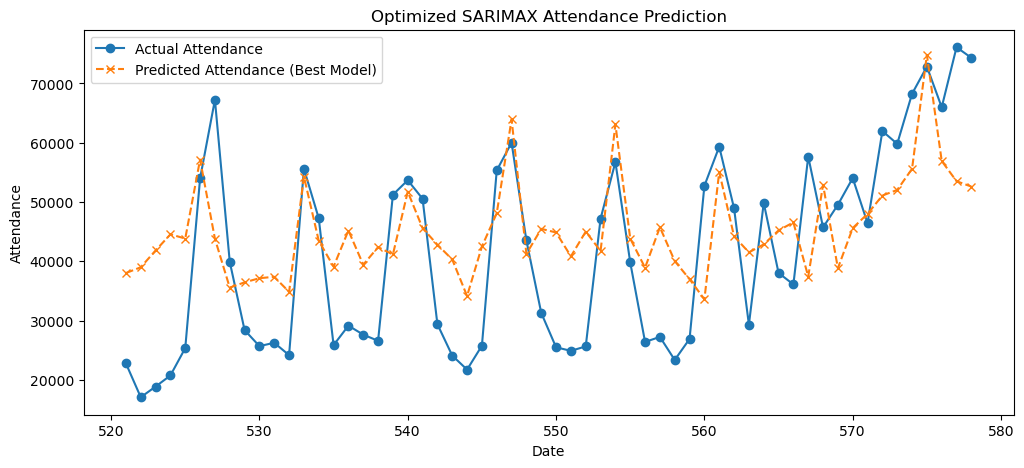

In [23]:
best_order, best_seasonal_order = best_params

final_model = SARIMAX(y_train, 
                      exog=X_train, 
                      order=best_order, 
                      seasonal_order=best_seasonal_order, 
                      enforce_stationarity=False, 
                      enforce_invertibility=False)
final_result = final_model.fit(disp=False)

# Predict
y_final_pred = final_result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)

# Plot Results
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label="Actual Attendance", marker='o')
plt.plot(y_test.index, y_final_pred, label="Predicted Attendance (Best Model)", marker='x', linestyle='dashed')
plt.legend()
plt.title("Optimized SARIMAX Attendance Prediction")
plt.xlabel("Date")
plt.ylabel("Attendance")
plt.show()


In [24]:
best_order

(1, 1, 1)

In [25]:
best_seasonal_order

(0, 1, 2, 7)

In [74]:
import itertools
import numpy as np
import pandas as pd

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error

df = merged_df.copy()
df.rename(columns={'USAGE_DATE': 'ds', 'attendance': 'y'}, inplace=True)
df.sort_values('ds', inplace=True)

# Split into train (90%) and test (10%)
split_index = int(len(df) * 0.9)
df_train = df.iloc[:split_index].copy()
df_test = df.iloc[split_index:].copy()

# Define smaller parameter grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1],
    'seasonality_prior_scale': [1.0, 10.0],
    'seasonality_mode': ['additive']
}

all_params = [
    dict(zip(param_grid.keys(), v))
    for v in itertools.product(*param_grid.values())
]

lowest_rmse = float('inf')
best_params = None
cv_results = []

# --- Adjusted cross-validation settings ---
initial = '200 days'   # e.g. first 200 days for training
horizon = '30 days'    # forecast 30 days ahead
period = '60 days'     # step every 60 days for the next cutoff

for params in all_params:
    m = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        seasonality_mode=params['seasonality_mode']
    )
    
    # Add external regressors as needed
    m.add_regressor('temp')
    m.add_regressor('pressure')
    m.add_regressor('wind_speed')
    m.add_regressor('weather_description_encoded')
    m.add_regressor('day')
    m.add_regressor('month')
    m.add_regressor('day_of_week')
    
    # Fit on the training set
    m.fit(df_train)
    
    # Cross-validation on the *training set*
    df_cv = cross_validation(
        m,
        initial=initial,
        horizon=horizon,
        period=period,
        parallel="processes"
    )
    df_perf = performance_metrics(df_cv, rolling_window=1)
    rmse = df_perf['rmse'].values[0]
    
    cv_results.append((params, rmse))
    if rmse < lowest_rmse:
        lowest_rmse = rmse
        best_params = params

print("Best Parameters from cross-validation:", best_params)
print("Lowest CV RMSE:", lowest_rmse)

# Retrain model with best params on df_train
best_model = Prophet(**best_params)
best_model.add_regressor('temp')
best_model.add_regressor('pressure')
best_model.add_regressor('wind_speed')
best_model.add_regressor('weather_description_encoded')
best_model.add_regressor('day')
best_model.add_regressor('month')
best_model.add_regressor('day_of_week')

best_model.fit(df_train)

# Evaluate on df_test
forecast_test = best_model.predict(df_test)
y_pred = forecast_test['yhat'].values
y_true = df_test['y'].values
rmse_test = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Prophet RMSE on test set with best hyperparams: {rmse_test:.3f}")


17:57:58 - cmdstanpy - INFO - Chain [1] start processing
17:57:58 - cmdstanpy - INFO - Chain [1] done processing
17:58:00 - cmdstanpy - INFO - Chain [1] start processing
17:58:00 - cmdstanpy - INFO - Chain [1] done processing
17:58:00 - cmdstanpy - INFO - Chain [1] start processing
17:58:00 - cmdstanpy - INFO - Chain [1] start processing
17:58:00 - cmdstanpy - INFO - Chain [1] done processing
17:58:00 - cmdstanpy - INFO - Chain [1] start processing
17:58:00 - cmdstanpy - INFO - Chain [1] start processing
17:58:00 - cmdstanpy - INFO - Chain [1] start processing
17:58:00 - cmdstanpy - INFO - Chain [1] start processing
17:58:00 - cmdstanpy - INFO - Chain [1] done processing
17:58:00 - cmdstanpy - INFO - Chain [1] done processing
17:58:00 - cmdstanpy - INFO - Chain [1] done processing
17:58:00 - cmdstanpy - INFO - Chain [1] done processing
17:58:00 - cmdstanpy - INFO - Chain [1] start processing
17:58:00 - cmdstanpy - INFO - Chain [1] done processing
17:58:00 - cmdstanpy - INFO - Chain [1]

Best Parameters from cross-validation: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive'}
Lowest CV RMSE: 12454.521812985604
Prophet RMSE on test set with best hyperparams: 8437.707


17:58:15 - cmdstanpy - INFO - Chain [1] start processing
17:58:15 - cmdstanpy - INFO - Chain [1] done processing


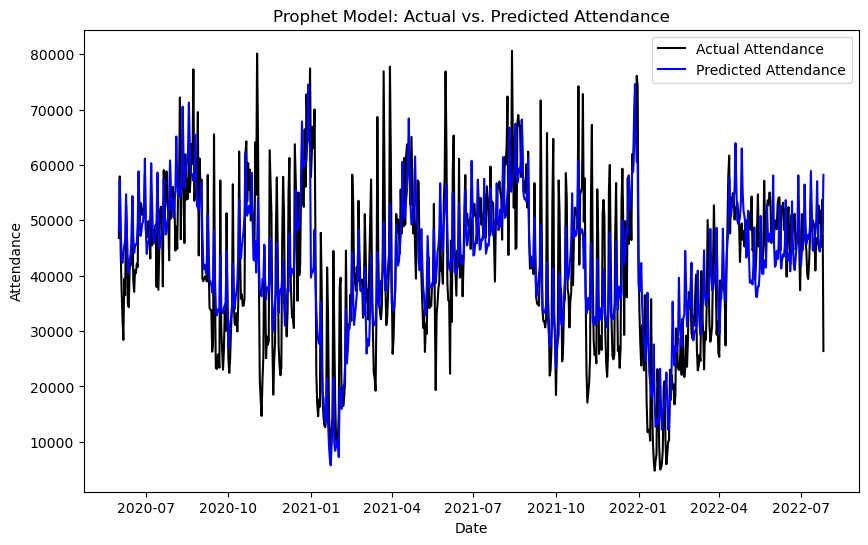

In [75]:
import matplotlib.pyplot as plt

# Suppose df is your entire dataset with columns 'ds', 'y', and the regressors.
# You already have best_params from your hyperparameter tuning step.

# 1) Initialize the model with the best parameters
best_model = Prophet(**best_params)

# 2) Add your extra regressors again
best_model.add_regressor('temp')
best_model.add_regressor('pressure')
best_model.add_regressor('wind_speed')
best_model.add_regressor('weather_description_encoded')
best_model.add_regressor('day')
best_model.add_regressor('month')
best_model.add_regressor('day_of_week')

# 3) Fit on the entire dataset
best_model.fit(df)

# 4) Generate predictions for every row in df
forecast_all = best_model.predict(df)


# Plot the entire dataset
plt.figure(figsize=(10, 6))

# Actual values (attendance)
plt.plot(df['ds'], df['y'], label='Actual Attendance', color='black')

# Predicted values (Prophet forecast)
plt.plot(forecast_all['ds'], forecast_all['yhat'], label='Predicted Attendance', color='blue')

plt.title('Prophet Model: Actual vs. Predicted Attendance')
plt.xlabel('Date')
plt.ylabel('Attendance')
plt.legend()
plt.show()


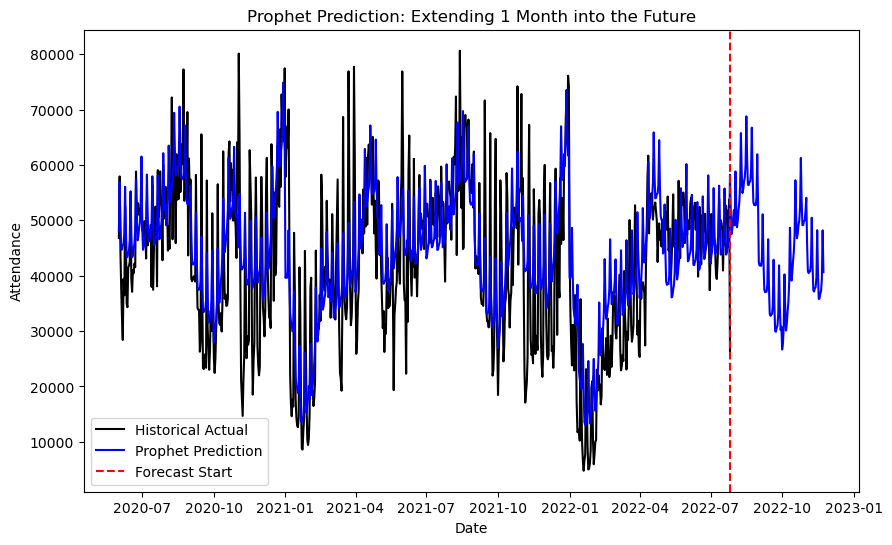

In [79]:
# 1) Create a new dataframe that extends 30 days beyond the last date in df
future_periods = 120  # ~1 month
df_future = best_model.make_future_dataframe(periods=future_periods, freq='D')

# Ensure the same columns exist in df_future as in your training data
# For illustration, we use simple placeholders or repeated values from the last known day.
# In a real scenario, you should supply actual forecasts or best estimates.

last_known_row = df.iloc[-1]  # your final historical row

df_future['temp'] = last_known_row['temp']
df_future['pressure'] = last_known_row['pressure']
df_future['wind_speed'] = last_known_row['wind_speed']
df_future['weather_description_encoded'] = last_known_row['weather_description_encoded']

# If you have 'day', 'month', 'day_of_week' as numeric columns in df, 
# you'll need to compute them for each row in df_future['ds'] (the new dates).
df_future['day'] = df_future['ds'].dt.day
df_future['month'] = df_future['ds'].dt.month
df_future['day_of_week'] = df_future['ds'].dt.dayofweek


forecast_new = best_model.predict(df_future)


import matplotlib.pyplot as plt

# 4.1) Combine the original forecast (for the historical period) and the new one
#     If you originally had 'forecast_all' for the historical fit, you can just re-use that.
#     Or simply use 'forecast_new' since it includes historical + future if you used the entire df in make_future_dataframe.

plt.figure(figsize=(10, 6))

# Historical actual
plt.plot(df['ds'], df['y'], label='Historical Actual', color='black')

# Prophet’s fitted + forecast
plt.plot(forecast_new['ds'], forecast_new['yhat'], label='Prophet Prediction', color='blue')

# Optional: highlight future portion (the last 30 days)
# This is how you can visually distinguish forecast from the fitted region
plt.axvline(x=df['ds'].max(), color='red', linestyle='--', label='Forecast Start')

plt.title('Prophet Prediction: Extending 1 Month into the Future')
plt.xlabel('Date')
plt.ylabel('Attendance')
plt.legend()
plt.show()
